In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [34]:
df = pd.read_csv("S&P_500_Index_Data.csv", parse_dates=['date'], index_col='date')

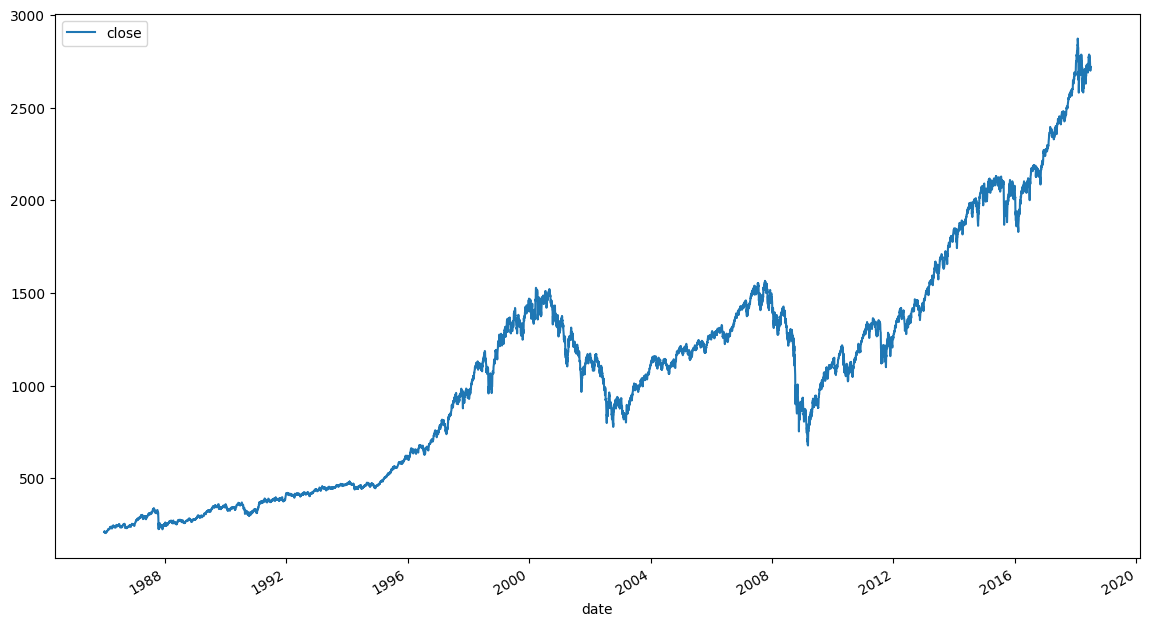

In [35]:
df.plot(figsize=(14,8))
plt.show()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8192 entries, 1986-01-02 to 2018-06-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   8192 non-null   float64
dtypes: float64(1)
memory usage: 128.0 KB


In [37]:
df.describe()

,close
count,8192.000000
mean,1070.897411
std,616.714534
min,203.490000
25%,458.632500
50%,1106.435000
75%,1388.132500
max,2872.870000


In [38]:
TIMESTEPS = 30            

train_data, test_data = train_test_split(df, train_size=0.95, shuffle=False)
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)
train_data.shape, test_data.shape

((7782, 1), (410, 1))

In [39]:
train_data

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97
...,...
2016-11-04,2085.18
2016-11-07,2131.52
2016-11-08,2139.56


In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7782 entries, 1986-01-02 to 2016-11-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   7782 non-null   float64
dtypes: float64(1)
memory usage: 121.6 KB


In [41]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 410 entries, 2016-11-11 to 2018-06-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   410 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB


In [42]:
def getScaledData(method='standard', train_df=None, test_df=None, feature_col='feature'):
    if method == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler = scaler.fit(train_df[[feature_col]])
    train_df['scaled_'+feature_col] = scaler.transform(train_df[[feature_col]])
    test_df['scaled_'+feature_col] = scaler.transform(test_df[[feature_col]])
    return train_df, test_df, scaler
    
def createDataset(df, lookback=30, feature_col=None):
    data_x, data_y = [], []
    for i in range(lookback, len(df)):
        data_x.append(df.iloc[i-lookback:i][[feature_col]].values)
        data_y.append(df.iloc[i][feature_col])
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return data_x, data_y

In [43]:
train_df, test_df, scaler = getScaledData('standard', train_data, test_data, 'close')
train_df.shape, test_df.shape

((7782, 2), (410, 2))

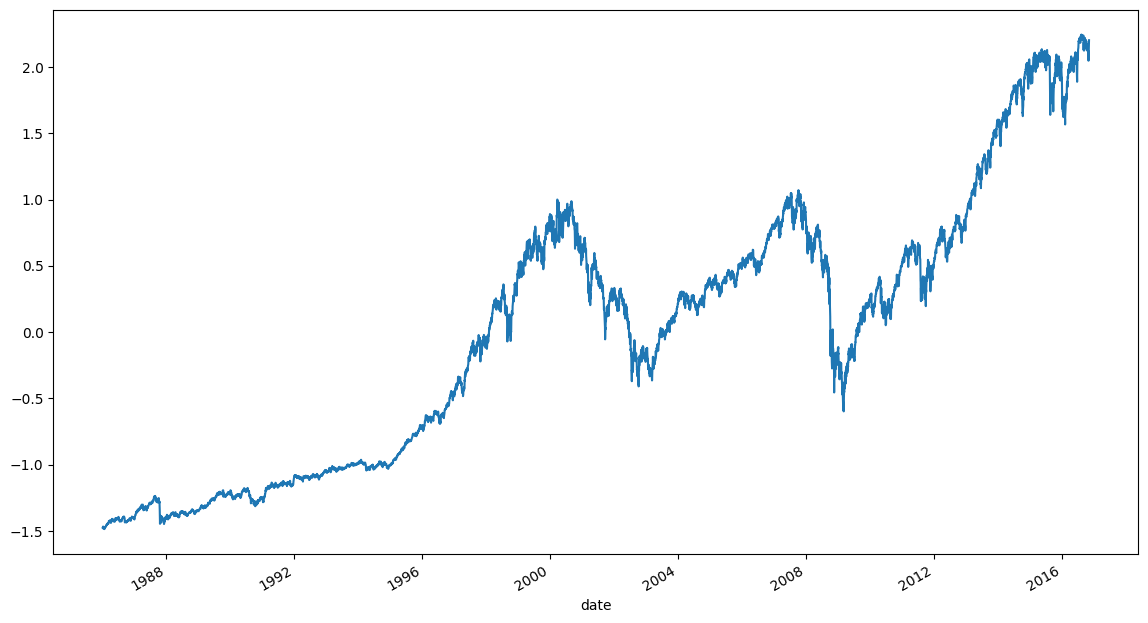

In [44]:
train_df['scaled_close'].plot(figsize=(14,8))
plt.show()

In [45]:
train_x, train_y = createDataset(train_df, TIMESTEPS, 'scaled_close')
test_x, test_y = createDataset(test_df, TIMESTEPS, 'scaled_close')

In [46]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((7752, 30, 1), (7752,), (380, 30, 1), (380,))

In [47]:
LSTM_units = 64
model = keras.Sequential()
model.add(LSTM(LSTM_units, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=False,name='encoder_lstm'
              ))
model.add(Dropout(0.2, name='encoder_dropout'))
model.add(RepeatVector(train_x.shape[1], name='decoder_repeater'))
model.add(LSTM(LSTM_units, return_sequences=True, name='decoder_lstm'))
model.add(Dropout(rate=0.2, name='decoder_dropout'))
model.add(TimeDistributed(Dense(train_x.shape[2],name='decoder_dense_output')))

model.compile(loss='mae', optimizer='adam')

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_lstm (LSTM)         (None, 64)                16896     
                                                                 
 encoder_dropout (Dropout)   (None, 64)                0         
                                                                 
 decoder_repeater (RepeatVec  (None, 30, 64)           0         
 tor)                                                            
                                                                 
 decoder_lstm (LSTM)         (None, 30, 64)            33024     
                                                                 
 decoder_dropout (Dropout)   (None, 30, 64)            0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            65        
 tributed)                                            

In [49]:
%time history = model.fit(train_x, train_x, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
218/218 [==============================] - 12s 38ms/step - loss: 0.1573 - val_loss: 0.3075
Epoch 2/10
218/218 [==============================] - 8s 36ms/step - loss: 0.0873 - val_loss: 0.3229
Epoch 3/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1293 - val_loss: 0.2032
Epoch 4/10
218/218 [==============================] - 9s 40ms/step - loss: 0.1287 - val_loss: 0.2221
Epoch 5/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1301 - val_loss: 0.1892
Epoch 6/10
218/218 [==============================] - 8s 39ms/step - loss: 0.1267 - val_loss: 0.1935
Epoch 7/10
218/218 [==============================] - 7s 34ms/step - loss: 0.1379 - val_loss: 0.2334
Epoch 8/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1392 - val_loss: 0.1901
Epoch 9/10
218/218 [==============================] - 8s 35ms/step - loss: 0.1360 - val_loss: 0.2020
Epoch 10/10
218/218 [==============================] - 8s 36ms/step - loss: 0.1347 - val_l

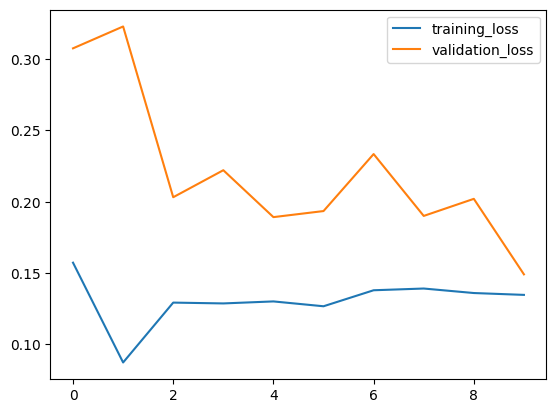

In [50]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

In [51]:
reconstructed = model.predict(train_x)
reconstructed.shape, train_x.shape

243/243 [==============================] - 8s 26ms/step


((7752, 30, 1), (7752, 30, 1))

In [52]:
mae_loss = np.mean(np.abs(reconstructed - train_x), axis=1)
mae_loss.shape

(7752, 1)

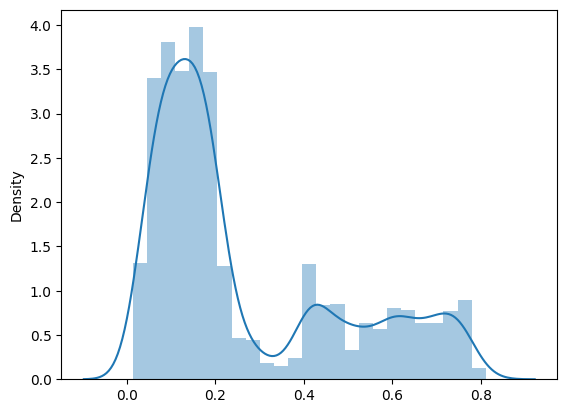

In [53]:
sns.distplot(mae_loss[:,0])
plt.show()

In [54]:
THRESHOLD = 0.65
test_reconstruction = model.predict(test_x)
test_reconstruction.shape

12/12 [==============================] - 0s 12ms/step


(380, 30, 1)

In [55]:
# MAE for reconstruction on test data
test_mae_loss = np.mean(np.abs(test_x - test_reconstruction), axis=1)
test_mae_loss.shape

(380, 1)

In [56]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 410 entries, 2016-11-11 to 2018-06-29
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   close         410 non-null    float64
 1   scaled_close  410 non-null    float64
dtypes: float64(2)
memory usage: 9.6 KB


In [57]:
# Setting index after N timesteps from past in test_df
anomaly_results_df = test_df[TIMESTEPS:][['close', 'scaled_close']].copy()
anomaly_results_df.index = test_df[TIMESTEPS:].index

# Including reconstructed predictions
anomaly_results_df['deviation'] = test_mae_loss
anomaly_results_df['threshold'] = THRESHOLD
anomaly_results_df['anomaly'] = anomaly_results_df['deviation'].apply(lambda dev: 1 if dev > THRESHOLD else 0)


anomalies = anomaly_results_df[anomaly_results_df['anomaly'] == 1]
anomalies.shape

(192, 5)

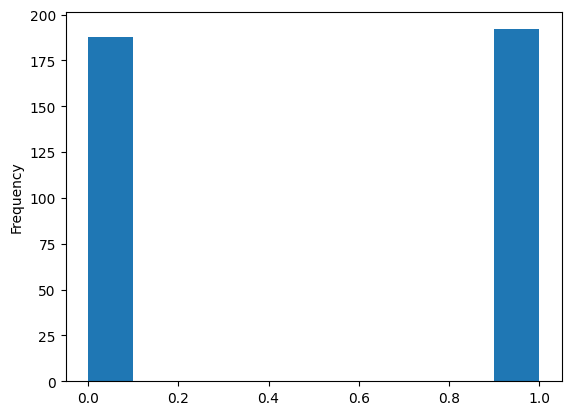

In [58]:
anomaly_results_df['anomaly'].plot(kind='hist')
plt.show()

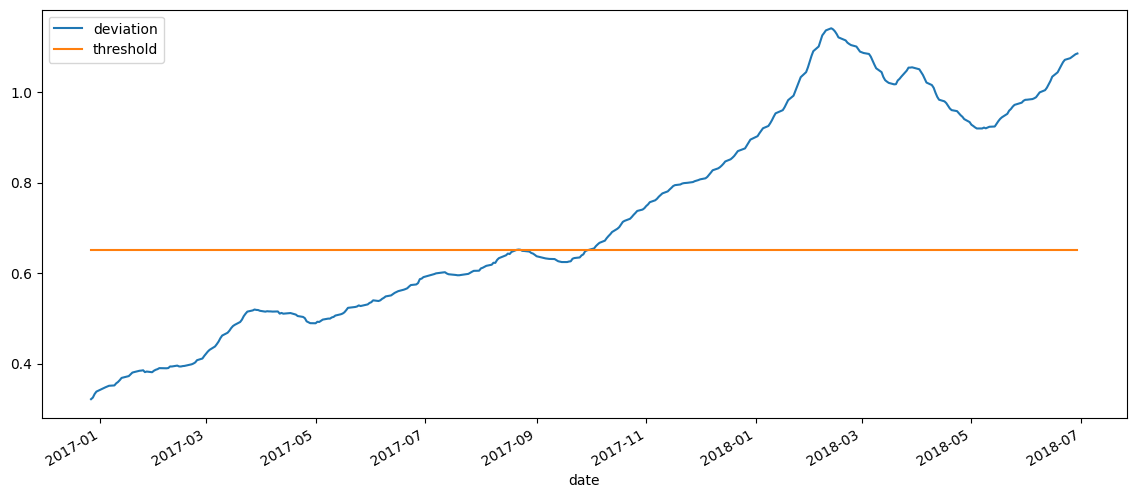

In [59]:
anomaly_results_df[['deviation', 'threshold']].plot(figsize=(14, 6))
plt.show()

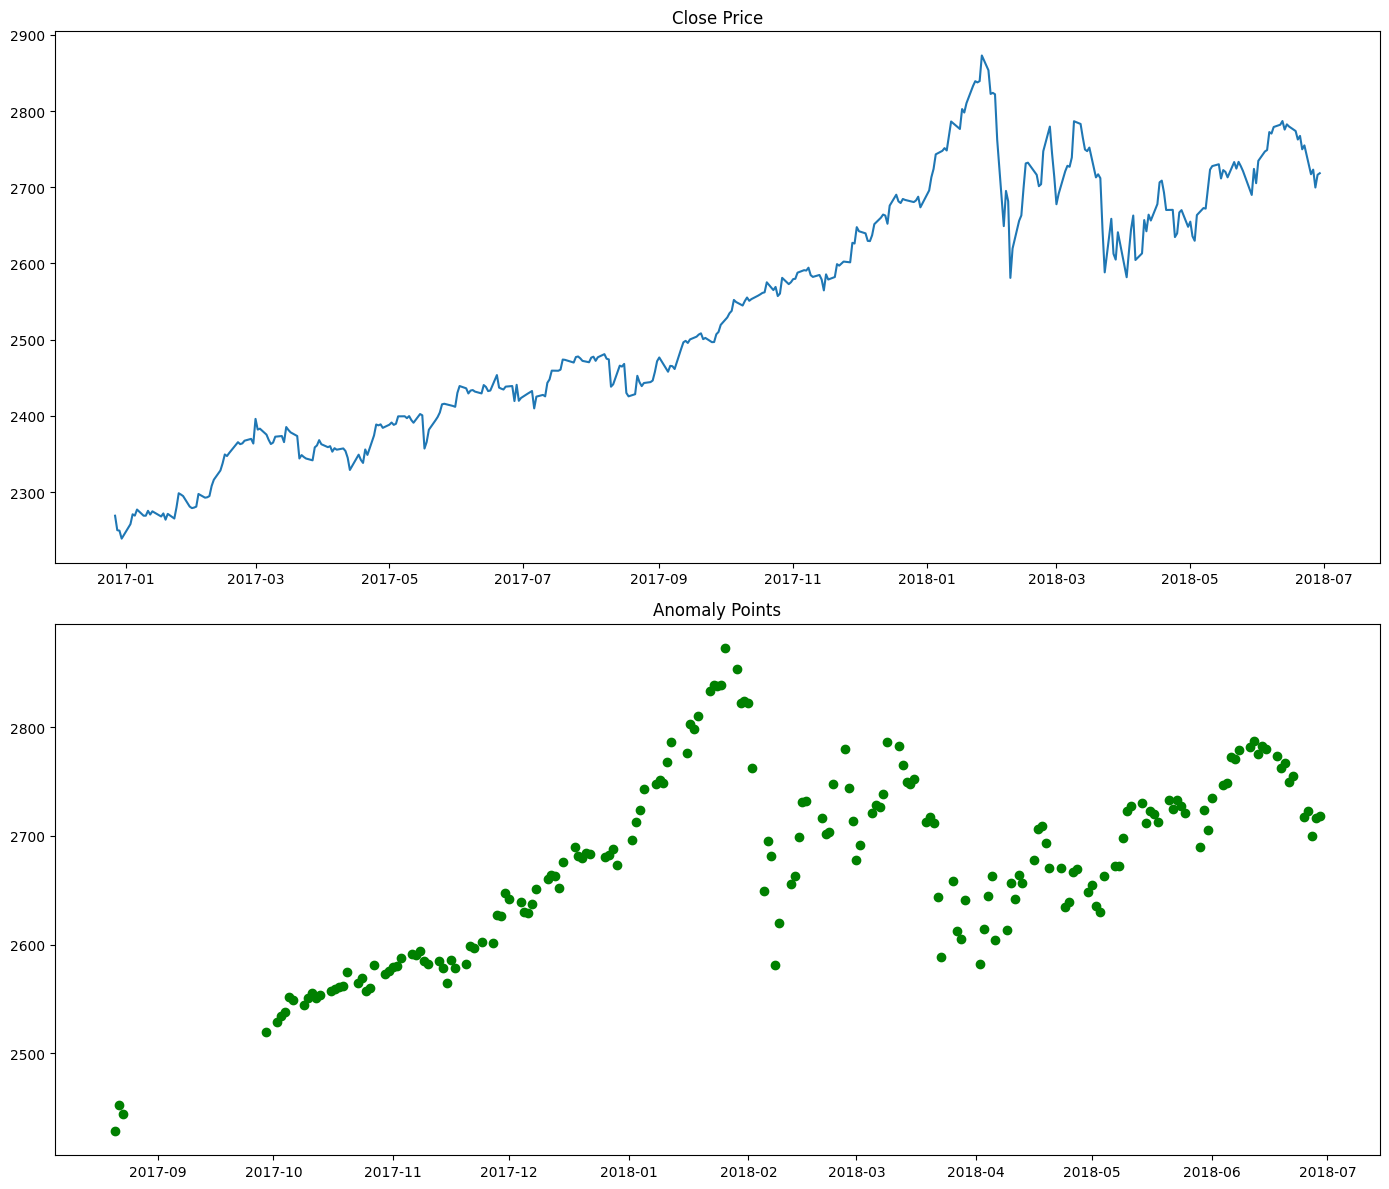

In [64]:
import matplotlib.pyplot as plt

# create a grid of subplots with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# plot the close price in the first subplot
axs[0].plot(anomaly_results_df['close'])
axs[0].set_title('Close Price')

# plot the anomaly points in the second subplot
anomalies = anomaly_results_df.loc[anomaly_results_df['anomaly'] == 1]
axs[1].scatter(anomalies.index, anomalies['close'], color='green')
axs[1].set_title('Anomaly Points')

# show the plot
plt.tight_layout()
plt.show()


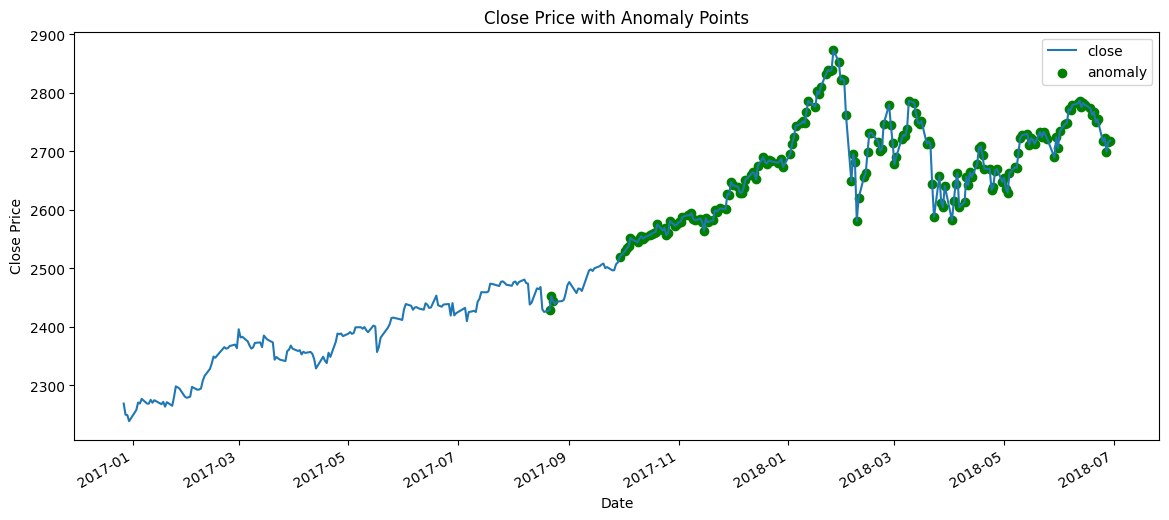

In [63]:
import matplotlib.pyplot as plt

# plot the close price
anomaly_results_df[['close']].plot(figsize=(14, 6))

# plot the anomaly points
anomalies = anomaly_results_df.loc[anomaly_results_df['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['close'], color='green', label='anomaly')

# set plot title and labels
plt.title('Close Price with Anomaly Points')
plt.xlabel('Date')
plt.ylabel('Close Price')

# show the plot
plt.legend()
plt.show()


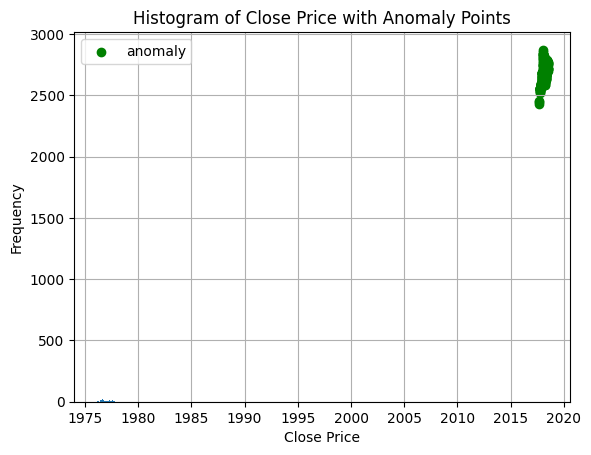

In [68]:
import matplotlib.pyplot as plt

# plot the histogram of the close price
anomaly_results_df['close'].hist(bins=50)

# plot the anomaly points
anomalies = anomaly_results_df.loc[anomaly_results_df['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['close'], color='green', label='anomaly')

# set plot title and labels
plt.title('Histogram of Close Price with Anomaly Points')
plt.xlabel('Close Price')
plt.ylabel('Frequency')

# show the plot
plt.legend()
plt.show()


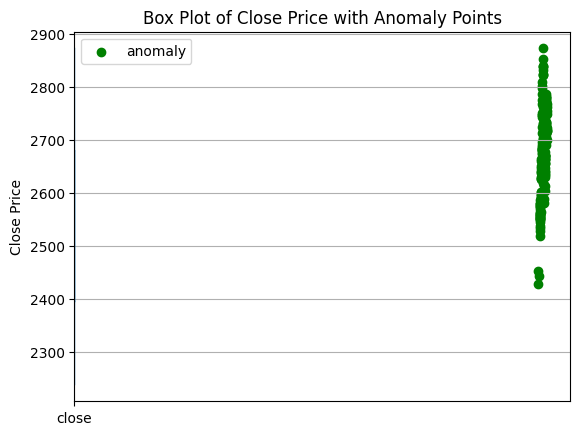

In [71]:
import matplotlib.pyplot as plt

# create a box plot of the close price
anomaly_results_df.boxplot(column=['close'])

# plot the anomaly points
anomalies = anomaly_results_df.loc[anomaly_results_df['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['close'], color='green', label='anomaly')

# set plot title and labels
plt.title('Box Plot of Close Price with Anomaly Points')
plt.ylabel('Close Price')

# show the plot
plt.legend()
plt.show()


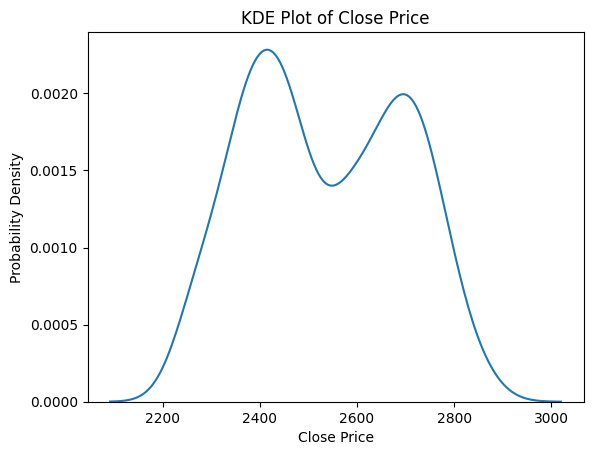

In [67]:
import seaborn as sns

# create a KDE plot of the close price
sns.kdeplot(anomaly_results_df['close'])

# set plot title and labels
plt.title('KDE Plot of Close Price')
plt.xlabel('Close Price')
plt.ylabel('Probability Density')

# show the plot
plt.show()


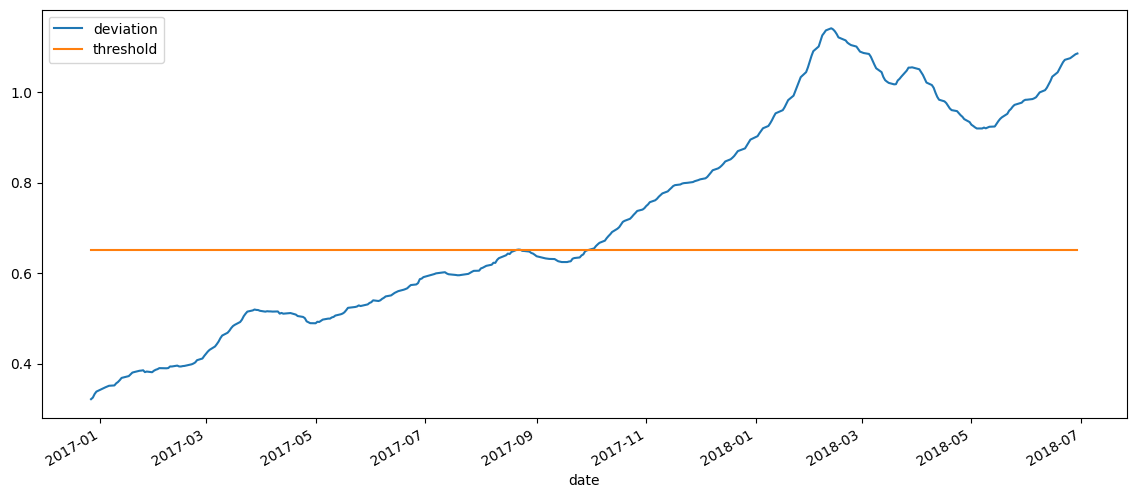

In [61]:
anomaly_results_df[['deviation', 'threshold']].plot(figsize=(14, 6))
plt.show()

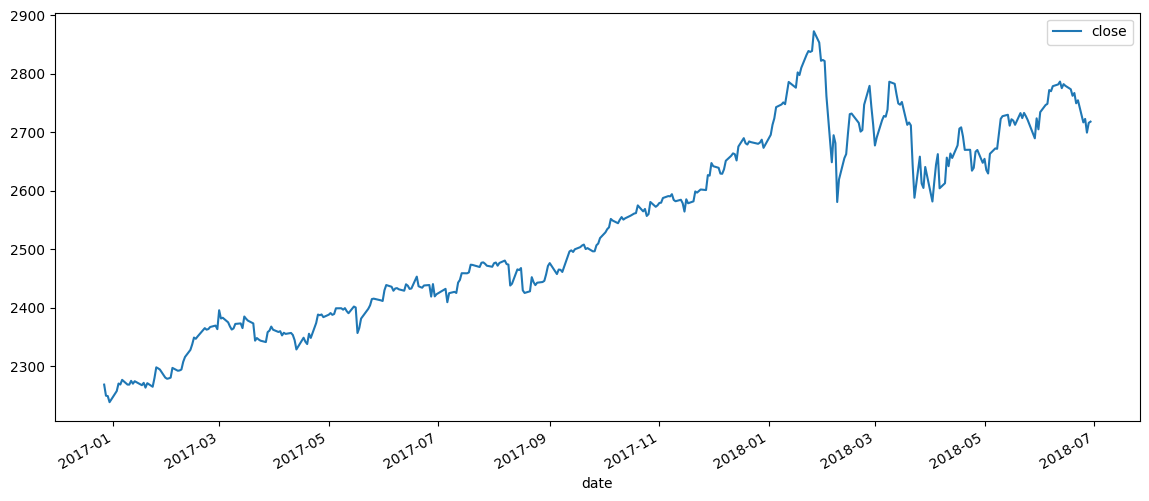

In [ ]:
anomaly_results_df[['close']].plot(figsize=(14, 6))
sns.scatterplot(x=anomalies.index, y=anomalies['close'], label='anomaly', color='red')
plt.show()
